# Analysis of Wang, Bonner, et al, 1989 thermal cracking data

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import savgol_filter as savgol
from scipy.interpolate import griddata, interp1d
import pysindy as ps
import pandas as pd
from scipy.integrate import odeint

from sklearn.metrics import mean_squared_error as mse

import graphviz

## Prelims

Wang, Bonner etal (WB) heated Westerly granite samples at 3 different confining pressures (7, 28 and 55 MPa) and, among other things, recorded acoustic emmissions (AEs) during the heating process. Assumption that AEs represent cracking events, and therefore the total number of AEs is proportional to total cracks, and AE rate is proportional to crack rate.

Experiments were performed at a temperature ramp of $1^{\circ}$C per minute.

Data was picked off the plots in the WB paper by Ben Holtzman.

Below, data is reconfigured such that temp and Aes are rescale to a 1 second timescale and smoothed.  Then smoothed derivative of AEs is taken (using pySINDy package) to get AE rate.

### Preliminary definitions

In [2]:
# derivative options
smoothed_dxdt = ps.SmoothedFiniteDifference(smoother_kws={'window_length':31, 'polyorder':1})
dxdt = ps.FiniteDifference()

svg_len = 21
svg_ord = 1

def create_df(df, P, diff=None, svg_len=None, svg_ord=None):
    """Creates a standardized dataframe from the Wang and Bonner data
    digitized by B. Holtzman.
    
    Args:
    ----------
        df (Pandas DataFrame): DataFrame created by reading in the csv files
        P (numerical): Pressure for the run
        diff: pySINDy differentiation class. Must implement a _differentiate method.
            Default=None
        svg_len (odd int, None): length of savgol filter. None if no smoothing required.
            Default=None
        svg_ord (int, None): order of savgol filter. None if no smoothing required
            Default=None
            
    Returns:
    -----------
        pandas DataFrame
    """

    # create a consistent timescale of 1 second intervals
    rezeroed_time = (df.temp - df.temp[0]).values
    total_time = np.ceil(rezeroed_time[-1])
    t = np.arange(0,total_time,1)

    # interpolate aes on this timescale
    interpolate_ae = interp1d(rezeroed_time, df['ae_tot'], kind='quadratic')
    ae_tot = interpolate_ae(t)
    
    if (svg_len is not None) & (svg_ord is not None):
        ae_tot = savgol(ae_tot, svg_len, svg_ord)
        
    # rezero aes - if they start at non zero value, and set any negatives to zero
    ae_tot = np.maximum(0,ae_tot - ae_tot[0])
    
    # interpolate temp
    interpolate_temp = interp1d(rezeroed_time, df['temp'], kind='quadratic')
    temp = interpolate_temp(t)
    #df['ae_tot'] = np.maximum(0, savgol(df['ae_tot'], svg_len, svg_ord))
    ae_rate = np.squeeze(diff._differentiate(ae_tot[:,None], t=t))
    
    # assumes equal timesteps
    #ae_rate = np.diff(ae_tot)#.diff().fillna(0)
    new_df = pd.DataFrame({'time':t,'temp':temp, 'ae_tot':ae_tot, 'ae_rate':ae_rate}).fillna(0)
    new_df['P'] = P
    return new_df
  
def plot_aes(df, title_text):
    """Plot total AEs and AE rate.
    """
    
    f,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(df['temp'],df['ae_tot'], label='Total')
    ax.set_ylabel('Total')

    ax2 = ax.twinx()
    ax2.plot(df['temp'],df['ae_rate'], color='orange', label='Rate')
    ax2.set_ylabel('Rate')
    ax2.set_xlabel('Temp')

    plt.legend()
    plt.title(title_text)
    plt.xlabel('Time')
    plt.show()

### Load data and resample, smooth

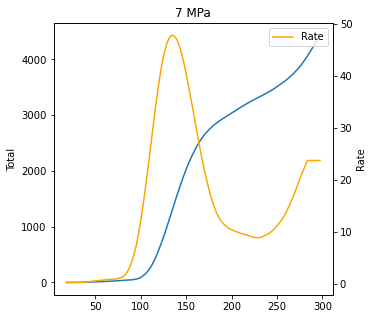

,time,temp,ae_tot,ae_rate,P
0,0.0,18.328446,0.000000,0.310088,7
1,1.0,19.328446,0.000000,0.310088,7
2,2.0,20.328446,0.000000,0.310088,7
3,3.0,21.328446,0.000000,0.310088,7
4,4.0,22.328446,0.000000,0.310088,7
...,...,...,...,...,...
275,275.0,293.328446,4324.444575,23.731799,7
276,276.0,294.328446,4351.449181,23.731799,7
277,277.0,295.328446,4378.453787,23.731799,7
278,278.0,296.328446,4405.458393,23.731799,7


In [3]:
ae7mpa = pd.read_csv('totAEs_T_07MPa.csv', names=['temp','ae_tot'])
ae7mpa = create_df(ae7mpa, 7, smoothed_dxdt, svg_len, svg_ord)
    
plot_aes(ae7mpa, '7 MPa')
ae7mpa

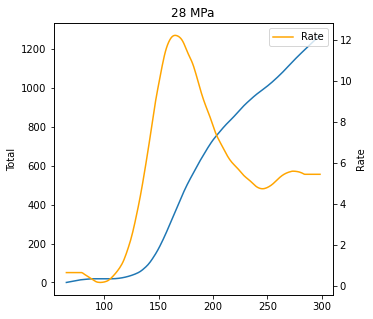

In [4]:
ae28mpa = pd.read_csv('totAEs_T_28MPa.csv', names=['temp','ae_tot'])
ae28mpa = create_df(ae28mpa, 28, smoothed_dxdt, svg_len, svg_ord)
plot_aes(ae28mpa, '28 MPa')

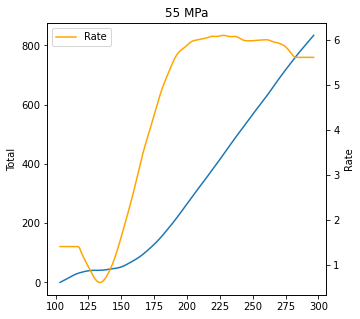

,time,temp,ae_tot,ae_rate,P
0,0.0,103.372434,0.000000,1.407034,55
1,1.0,104.372434,2.394519,1.407034,55
2,2.0,105.372434,4.789039,1.407034,55
3,3.0,106.372434,7.183558,1.407034,55
4,4.0,107.372434,9.578078,1.407034,55
...,...,...,...,...,...
189,189.0,292.372434,812.940965,5.610229,55
190,190.0,293.372434,818.167297,5.610229,55
191,191.0,294.372434,823.393628,5.610229,55
192,192.0,295.372434,828.619960,5.610229,55


In [5]:
ae55mpa = pd.read_csv('totAEs_T_55MPa.csv', names=['temp','ae_tot'])
ae55mpa = create_df(ae55mpa, 55, smoothed_dxdt, svg_len, svg_ord)
plot_aes(ae55mpa, '55 MPa')
ae55mpa

### Thermal cracking rate as a function of Temp and Pressure

In [6]:
# Look at thermal cracking as surface plot

# x, y = temp, pressure
# z = AE rate

points = list(zip(ae7mpa['temp'], ae7mpa['P'])) \
         + list(zip(ae28mpa['temp'], ae28mpa['P'])) \
         + list(zip(ae55mpa['temp'], ae55mpa['P']))

values = ae7mpa['ae_rate'].values.tolist() + ae28mpa['ae_rate'].values.tolist() + ae55mpa['ae_rate'].values.tolist()

grid_x, grid_y = np.meshgrid(range(18,301), range(7,56))

interp_aerate = griddata(points, values, (grid_x, grid_y), method='cubic')

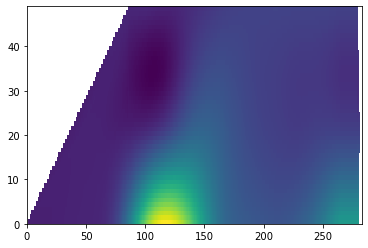

In [7]:
plt.pcolormesh(interp_aerate)

Text(0.5, 0, 'AE rate')

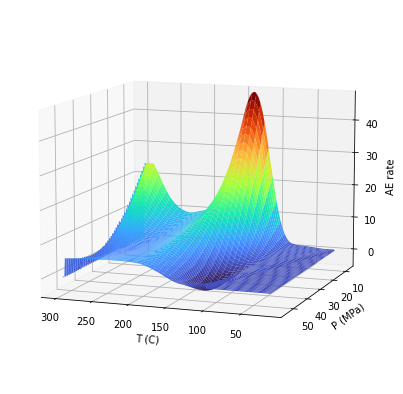

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

interp_aerate = np.nan_to_num(interp_aerate, 0)
ax.plot_surface(grid_x, grid_y, interp_aerate,cmap='turbo')
ax.view_init(10,110)
ax.set_xlabel('T (C)')
ax.set_ylabel('P (MPa)')
ax.set_zlabel('AE rate')

WB point out that the AE *rates* can be approximated by the sum of 1 to 3 gaussian curves, but do not provide an explanation.  Here we provide an empirical model that explains this observation.

#### Gaussian function

#### $ f(x) = A \, exp\left(- \frac{(x-\mu)^2}{\sigma^2}\right)$

#### Logistic distribution - derivative of logistic function

#### $ f(x) = \frac{A}{s} \, \frac{e^{(-(x-\mu)/s)}}{(1+e^{(-(x-\mu)/s)})^2} $

#### Thermally activated process

#### $ f(T) = A \, exp\left(\frac{-(Q+PV)}{RT}\right) $



/Users/nate/opt/anaconda3/envs/symbolicregression/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


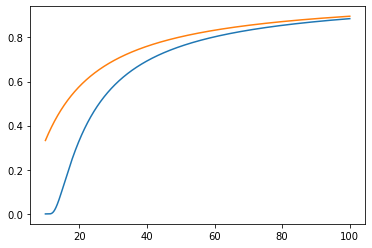

In [9]:
# Arrhenius-type eqn
class Arrhenius:
    def __init__(self, A, Q, V, T0=0):
        self.A, self.Q, self.V, self.T0= A,Q,V, T0
    def __call__(self, T,P):
        R = 1
        return self.A*np.exp(-(self.Q+P*self.V)/(R*(T-self.T0)))
    
generic_arr = Arrhenius(1,10,1,10)
x = np.arange(10, 100, 0.01)
            
    
plt.plot(x, generic_arr(x, 1))

generic_arr = Arrhenius(1,10,1,0)
plt.plot(x, generic_arr(x, 1))

In [10]:
import sympy

In [11]:
A, Q, P, V, R, T = sympy.symbols('A Q P V R T')

arrhenius = A*sympy.exp(-(Q+P*V)/(R*T))
sympy.Derivative(arrhenius, T).doit()

-A*(-P*V - Q)*exp((-P*V - Q)/(R*T))/(R*T**2)

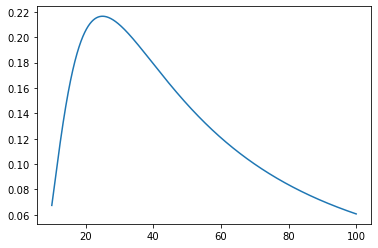

In [12]:
plt.plot(x, 1000*np.exp(-50/x)/x**2)

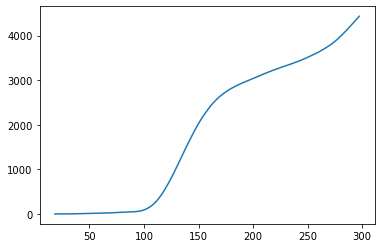

In [13]:
# Fit log ae tot

plt.plot(ae7mpa.temp, ae7mpa.ae_tot)

## SINDyC analysis

SINDyC doesn't find the governing equations with a simple polynomial library.  We could chooose a different library, but I'm suspicious that the problem isn't well posed for the basic method.  See SINDY-PI (finds rational functions, those with division of terms in the RHS of the ODEs) for a potentially more applicable method, or use genetic programming (see below).


In [14]:
# Response varible = ae_tot
# control variables: temp
# independent variables: time, pressure

# for 7 mpa

def ufunc(t):
    return t

model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.001),
                #differentiation_method=ps.SmoothedFiniteDifference(),
                feature_library=ps.PolynomialLibrary(degree=3))

aes = ae7mpa.ae_rate.values
us = ae7mpa.temp.values
ts = ae7mpa.time.values

#model.fit(ae7mpa.ae_tot.values, u=ae7mpa.temp.values, t=ae7mpa.time.values)
model.fit(aes, u=us, t=ts)#, multiple_trajectories=True)

/Users/nate/opt/anaconda3/envs/symbolicregression/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02142e-16): result may not be accurate.
  overwrite_a=True).T


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x0', 'u0'],
      optimizer=STLSQ(threshold=0.001))

In [15]:
model.print()

x0' = 0.109 1 + -0.002 x0


In [16]:
res = model.simulate(0, ae7mpa.time.values, u=ufunc)

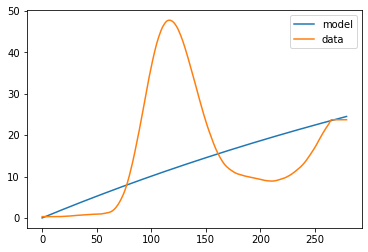

In [17]:
plt.plot(np.squeeze(res), label='model')
plt.plot(ae7mpa['ae_rate'], label='data')
plt.legend()
plt.show()

## Genetic Programming symbolic regression with gplearn

[gplearn](https://gplearn.readthedocs.io/en/stable/) is a python package that fllows the scikit-learn API (.fit, .transform).  It is used to perform symbolic regression over data, i.e., find a symbolic equation that bets fits the data.  This is similar to the SINDY family of methods.  However, while SINDY uses sparse regression techniques from linear algebra, gplearn uses [genetic programming](https://gplearn.readthedocs.io/en/stable/intro.html#intro). Genetic programming is a method analogouos to biological natural selection, where a population of candidate functions evloves over time to fit fit the data. Full explanation beyond scope for the moment. See above links.

In [18]:
# library with gaussian, arrhenius, logistic terms. See which ones and how many fit??

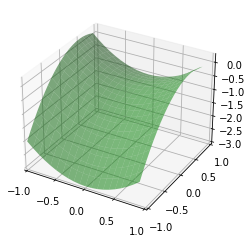

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.76m
   1     9.97          1.70233        5         0.320202         0.624787      1.06m
   2     7.72          1.94456       11         0.239537         0.533148     59.17s
   3     5.41         0.990157        7         0.235676         0.719906     57.44s
   4     4.66         0.894443       11         0.103946         0.103946     58.00s
   5     5.41         0.940242       11         0.060802         0.060802     43.95s
   6     6.78          1.09536       11      0.000781474      0.000781474     40.04s


SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

In [42]:
# Examples

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.utils.random import check_random_state
import graphviz

def plot_program_graph(program):
    dot_data = program.export_graphviz()
    return graphviz.Source(dot_data)

x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

In [43]:
print(est_gp._program)

sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


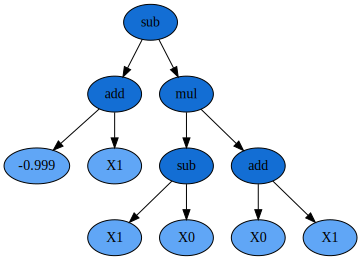

In [44]:
plot_program_graph(est_gp._program)

In [90]:
#Try on the WB data

# exp as custom function

# set numpy error handling
np.seterr(over='raise', under='raise', invalid='raise')

def _negexp(x):
    # make it HARD!
    try:
        return np.exp(-x)
    except:
        return np.finfo(float).eps

negexp = make_function(function=_negexp,
                        name='negexp',
                        arity=1)

from gplearn.functions import sig1 

#reshape data to conform to gplearn interface
X_train = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
y_train = interp_aerate.ravel()

WB_gp = SymbolicRegressor(population_size=5000,
                          function_set=['add', 'sub', 'mul', 'div', sig1, negexp],
                           generations=4, stopping_criteria=0.01,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.2, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=1000, #random_state=0,
                         n_jobs=3)
WB_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    19.71              nan       24              nan              nan     16.81s
   1    14.01              nan       12              nan              nan     14.87s
   2    35.93              nan       32              nan              nan     12.04s
   3    40.15              nan       66              nan              nan      0.00s


SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div',
                  generations=4, max_samples=0.9, n_jobs=3, p_crossover=0.6,
                  p_hoist_mutation=0.2, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=1000,
                  population_size=5000, stopping_criteria=0.01, verbose=1)

In [91]:
def collect_programs(est):
    """Removes all programs that are None"""
    generations = []
    for generation in est._programs:
        programs=[]
        for program in generation:
            if program is not None:
                programs.append(program)
        generations.append(programs)
    return generations

In [92]:
progs = collect_programs(WB_gp)

mul(negexp(sub(add(sub(sig(X0), negexp(-0.643)), div(negexp(0.277), negexp(X0))), negexp(sub(sub(X1, X0), sig(X1))))), add(div(sub(mul(add(-0.778, X0), div(X1, X0)), mul(add(X1, X1), negexp(X1))), mul(mul(negexp(-0.215), sig(X1)), negexp(div(0.229, 0.747)))), sub(mul(sub(sub(X0, 0.989), negexp(X1)), negexp(sub(X1, X1))), negexp(mul(negexp(X0), mul(X0, X1))))))
[5.18316346e-15 5.40908877e-15 5.63462614e-15 ... 7.90777306e-14
 7.92998922e-14 7.95220529e-14]
mse: 88.4476222522047


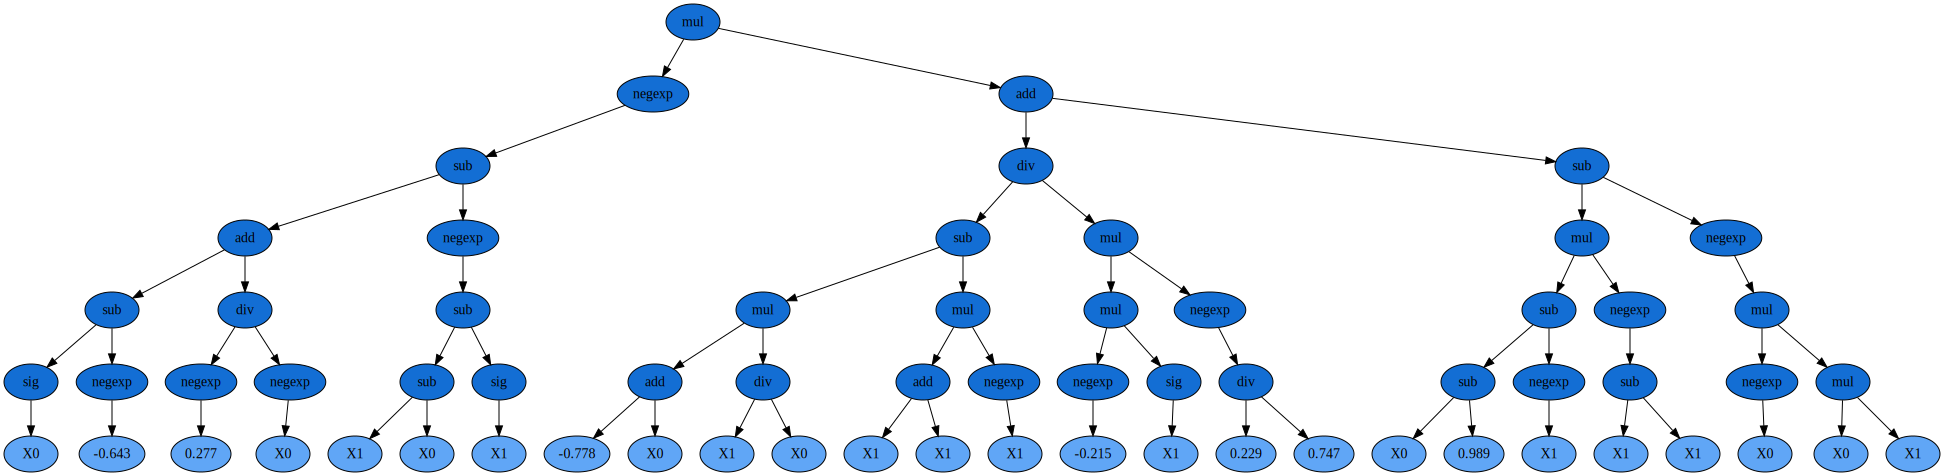

In [104]:
generation = -1
program_num = -2

prog = WB_gp._program#progs[generation][program_num]
print(prog)

yhat = prog.execute(X_train)
print(yhat)

error = mse(y_train, yhat)

print(f'mse: {error}')

plot_program_graph(prog)

# Would love to have a function that turns the gplearn function expression into a latex expression
# but that would involve writing a compiler. Maybe another time.

In [105]:
y_hat = prog.execute(X_train)
y_hat = y_hat.reshape((-1,grid_y.shape[0]))

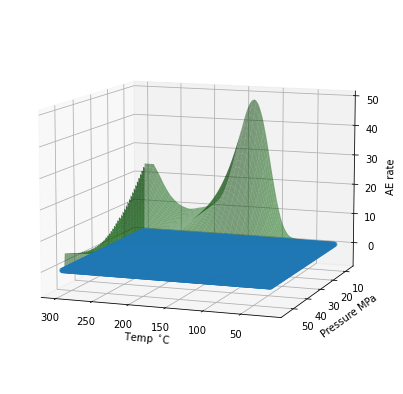

In [106]:
ax = plt.figure(figsize=(7,7)).gca(projection='3d')
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
surf = ax.plot_surface(grid_x, grid_y, interp_aerate,# rstride=1, cstride=1,
                       color='green', alpha=0.5, label='data')

ax.scatter(grid_x, grid_y, y_hat, label='fit')

ax.set_xlabel('Temp $\,^{\circ}$C')
ax.set_ylabel('Pressure MPa')
ax.set_zlabel('AE rate')
ax.view_init(10,110)

plt.show()

## Let's do this the old fashioned way, by inspection

WB fit gaussian curves to the crack rates.  I think the crack rates could be fit by the derivative of an Arrhenius equation, equivalently, the total AEs (presumed proportional to crack density) can be fit by an integral of an Arrhenius eqn.  This doesn't necessarily make a lot of theoretical sense, since the Arrhenius equation describes the dependence of a reaction rate on temperature (more generally enthalpy). Although crack density probably has an equilibrium value at a particular temperature and pressure, and a rate of cracking depenedent on both as well.  Unclear if the the WB experiemnts were at quasi-steady state, i.e., if the temperature ramp was slow enough that each point in time (temp) represents the equilibrium crack density. Might motivate some experiments - rampand hold temp, see crack rates at each.

Start simple.  Assume each curve is a sum of Gaussians, fit by hand.  Then, introduce a gaussian function into gplearn, see if it fits. If that works, try to find a symbolic regression method that will work with this functional form.  More generally, find or create a method that will work with thermodynamic equations. (Idea: hybrid model including bayesian or other sparse regression and optimization over multiple parameters in the equation - build a library of terms and parameters for those terms, optimize the parameters, including a sparse coefficient. More ideas - if we use a framework such as pytorch or tensorflow, which is already a graph language, it may be easier.  Would be great to integrate with sympy for symbolic manipulation and latex.)


### Only the 7 mpa data

Try to fit it with sum of logistic equations.

logistic function(x) = $\frac{L}{1+exp(-k(x-x_o))}$

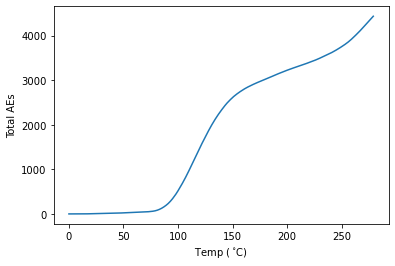

In [167]:
ae7mpa['ae_tot'].plot()
plt.xlabel('Temp ($\,^{\circ}$C)')
plt.ylabel('Total AEs')
plt.show()

In [116]:
class Logistic:
    """Create a logistic function of the form
    
    $\frac{L}{1+exp(-k*(x-x_o))}
    """
    def __init__(self, L, k, x0):
        self.L, self.k, self.x0 = L, k, x0
    def __call__(self, x):
        return self.L/(1+np.exp(-self.k*(x-self.x0)))
        

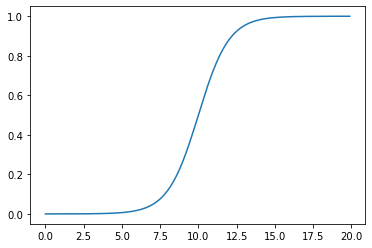

In [117]:
logistic = Logistic(1,1,10)
x = np.arange(0,20,0.1)
plt.plot(x,logistic(x))

#### Now, fit the 7 MPA data by iteragtive inspection (steps not shown)

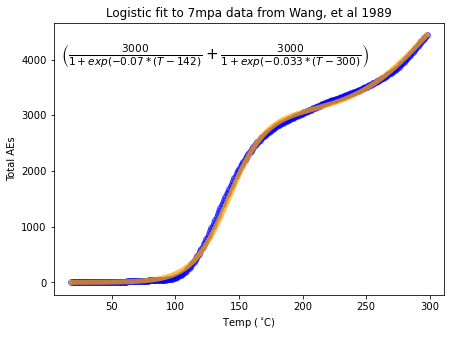

In [187]:
#define the2 logistic functions
logistic1 = Logistic(3000,0.07, 142 )
logistic2 = Logistic(3000,.033, 300)

# define their sum
fit = lambda x: logistic1(x) + logistic2(x)

#fit and plot data
plt.figure(figsize=(7,5))
plt.plot(ae7mpa['temp'], ae7mpa['ae_tot'], 'bo',  alpha=0.5,label='Data')
plt.plot(ae7mpa['temp'], fit(ae7mpa['temp']), 'orange', lw=5, alpha=0.75, label='Logistic model')
plt.xlabel('Temp ($\,^{\circ}$C)')
plt.ylabel('Total AEs')
plt.title('Logistic fit to 7mpa data from Wang, et al 1989')
plt.text(10,4000, r'$\left(\frac{3000}{1+exp(-0.07*(T-142)} + \frac{3000}{1+exp(-0.033*(T-300)}\right)$', fontsize=15)
plt.show()


#### Pretty good fit.

This was hand optimized.  Could use a different optimizer such as gradient descent or LBGFS in pytorch or tensorflow.

In [ ]:
### Now, can 